## BigQuery Magic - Query results to Pandas Dataframe
The following code uses Jupyter **magic** to load the results of a BigQuery query into a Pandas dataframe.

Note that we do not need to import any libraries!

In [1]:
%%bigquery stations_df --verbose
SELECT
  name, id,
  state,
  ST_GeogPoint(longitude, latitude) AS g
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
LIMIT
  1000

Executing query with job ID: 62dbe992-6bfd-4dc0-ab4f-4d13c0fb5d1f
Query executing: 0.43s
Query complete after 0.78s


In [2]:
stations_df.head()

,name,id,state,g
0,BOWEN CHEETHAM SALT,ASN00033094,,POINT(148.2247 -20.0133)
1,DUMBLETON ROCKS ALERT,ASN00033300,,POINT(149.0753 -21.1439)
2,ONE MILE BRIDGE ALERT,ASN00040836,,POINT(152.7461 -27.6272)
3,CURUCA,BR000047003,,POINT(-47.85 -0.73)
4,PRIMAVERA,BR000047004,,POINT(-47.1 -0.93)


## Location search via GIS
Now search for stations near Washinton DC.  You can set the lat long of another station in **ST_GeogPoint**

In [3]:
%%bigquery dc_stations_df --verbose
WITH params AS (
  SELECT ST_GeogPoint(-77.0032, 38.9) AS center,
         50 AS maxn_stations,
         50 AS maxdist_km
),
distance_from_center AS (
  SELECT
    id,
    name,
    state,
    ST_GeogPoint(longitude, latitude) AS loc,
    ST_Distance(ST_GeogPoint(longitude, latitude), params.center) AS dist_meters
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_stations`,
    params
  WHERE ST_DWithin(ST_GeogPoint(longitude, latitude), params.center, params.maxdist_km*1000)
)
SELECT * from distance_from_center

Executing query with job ID: 97f2137f-06fc-4934-a2d6-29ad563e2f8a
Query executing: 0.52s
Query complete after 0.84s


In [4]:
dc_stations_df.head()

,id,name,state,loc,dist_meters
0,US1DCDC0009,WASHINGTON 2.0 SSW,DC,POINT(-77.0224 38.8766),3087.351459
1,US1DCDC0007,WASHINGTON 1.2 SE,DC,POINT(-76.9982 38.8943),767.429691
2,US1DCDC0002,WASHINGTON 3.7 NNW,DC,POINT(-77.0337 38.9574),6906.390130
3,US1DCDC0019,THE WHITE HOUSE,DC,POINT(-77.037 38.8958),2962.079439
4,US1DCDC0010,WASHINGTON 5.0 N,DC,POINT(-77.0245 38.9773),8790.585440


## Use parameters in BigQuery search
Set the **lat** and **long** as python variables.

Note that we need to cast the **FLOAT64** as **String**, since Jupyter **BigQuery Magic** mis-interprets the negative sign as a variable.

In [5]:
long = -77.0032
lat  = 38.9
params = {"longitude": f'{long}', "latitude" : f'{lat}'}

Send the **JSON String** to the query via the **params** flag and then **CAST** them to **FLOAT64**.

In [6]:
%%bigquery dc_stations_2_df --params $params --verbose
WITH params AS (
  SELECT ST_GeogPoint(CAST(@longitude as FLOAT64), CAST(@latitude as FLOAT64)) AS center,
         50 AS maxn_stations,
         50 AS maxdist_km
),
distance_from_center AS (
  SELECT
    id,
    name,
    state,
    longitude, 
    latitude,
    ST_Distance(ST_GeogPoint(longitude, latitude), params.center) AS dist_meters
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_stations`,
    params
  WHERE ST_DWithin(ST_GeogPoint(longitude, latitude), params.center, params.maxdist_km*1000)
)
SELECT * from distance_from_center

Executing query with job ID: 88719e0e-1e15-49ef-acbc-1472090503ab
Query executing: 0.37s
Query complete after 0.74s


In [7]:
dc_stations_2_df.head()

,id,name,state,longitude,latitude,dist_meters
0,US1DCDC0009,WASHINGTON 2.0 SSW,DC,-77.0224,38.8766,3087.351459
1,US1DCDC0007,WASHINGTON 1.2 SE,DC,-76.9982,38.8943,767.429691
2,US1DCDC0002,WASHINGTON 3.7 NNW,DC,-77.0337,38.9574,6906.390130
3,US1DCDC0019,THE WHITE HOUSE,DC,-77.0370,38.8958,2962.079439
4,US1DCDC0010,WASHINGTON 5.0 N,DC,-77.0245,38.9773,8790.585440


## Plot the stations on a Map
Install and import **geopandas**

In [8]:
!pip install geopandas

In [9]:
import geopandas as gpd

Create a GeoDataFrame from the **pandas** DataFrame.

In [10]:
dc_geo_df = gpd.GeoDataFrame(dc_stations_2_df, geometry = gpd.points_from_xy(dc_stations_2_df.longitude, dc_stations_2_df.latitude))

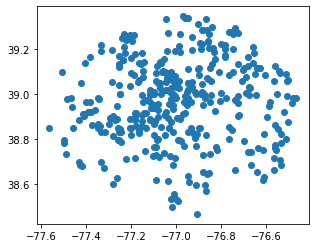

In [11]:
dc_geo_df.plot()

In [12]:
!pip install descartes

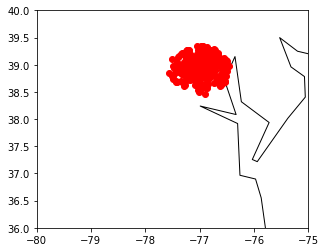

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
ax.set_xlim([-80, -75])
ax.set_ylim([36,40])
dc_geo_df.plot(ax=ax, color = 'red')

## Mashup w/ Airport Departure Data

In [14]:
%%bigquery airwx --verbose
SELECT
  wx.date,
  wx.prcp,
  f.departure_delay,
  f.arrival_airport
FROM (
  SELECT
    CAST(date as STRING) AS date,
    value/10 AS prcp
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_2005`
  WHERE
    id = 'USW00094846'
    AND qflag IS NULL
    AND element = 'PRCP') AS wx
JOIN
  `bigquery-samples.airline_ontime_data.flights` AS f
ON
  f.date = wx.date
WHERE
  f.departure_airport = 'ORD'

Executing query with job ID: 8eeecd4f-adac-4f15-b411-58ddd6a13649
Query executing: 0.57s
Query complete after 0.91s


In [15]:
airwx.head()

,date,prcp,departure_delay,arrival_airport
0,2005-09-29,0.0,88.0,IAH
1,2005-09-19,12.7,31.0,IAH
2,2005-09-28,15.0,29.0,IAH
3,2005-09-22,18.0,60.0,IAH
4,2005-08-05,0.0,32.0,IAH


## Plot an advanced chart -- Violin Plot

In [16]:
!pip install seaborn
import seaborn as sns

Text(0, 0.5, 'Flight delays (minutes)')

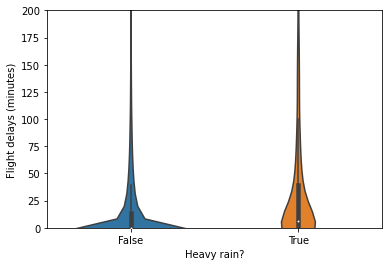

In [17]:
rainyday = airwx.prcp > 25.4 # 1 inch of rain
ax = sns.violinplot(x=rainyday, y=airwx.departure_delay)
ax.set_ylim(0, 200)
ax.set_xlabel('Heavy rain?')
ax.set_ylabel('Flight delays (minutes)')

## Plot a Timeseries chart

In [18]:
%%bigquery ts_df
SELECT
  date,
  MAX(prcp) AS prcp,
  MAX(tmin) AS tmin,
  MAX(tmax) AS tmax,
  IF(MAX(haswx) = 'True', 'True', 'False') AS haswx
FROM (
  SELECT
    wx.date,
    IF (wx.element = 'PRCP', wx.value/10, NULL) AS prcp,
    IF (wx.element = 'TMIN', wx.value/10, NULL) AS tmin,
    IF (wx.element = 'TMAX', wx.value/10, NULL) AS tmax,
    IF (SUBSTR(wx.element, 0, 2) = 'WT', 'True', NULL) AS haswx
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_2020` AS wx
  WHERE
    id = 'USW00013743'
    AND qflag IS NULL )
GROUP BY
  date
ORDER BY
  date

In [19]:
ts_df.head()

,date,prcp,tmin,tmax,haswx
0,2020-01-01,0.0,1.7,10.6,False
1,2020-01-02,0.0,0.0,12.2,False
2,2020-01-03,6.4,7.8,11.7,True
3,2020-01-04,7.9,7.8,15.0,True
4,2020-01-05,0.0,2.2,7.8,False


In [20]:
ts_df['rain'] = ts_df.apply(lambda x: True if x.prcp > 0 else False, axis = 1)

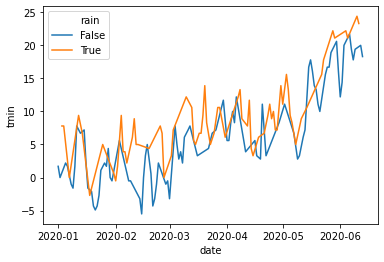

In [21]:
sns.lineplot(x="date", y="tmin",hue="rain",data=ts_df)